In [1]:
# Dependencies
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from adjustText import adjust_text
import numpy as np

import nfl_data_py as nfl

In [2]:
# Turn off max columns for pandas DataFrame
pd.set_option('display.max_columns', None)

In [3]:
years = range(2016, 2023)

In [4]:
data = nfl.import_pbp_data(years, cache=True, alt_path="../cache")

1999 done.
2000 done.
2001 done.
2002 done.
2003 done.
2004 done.
2005 done.
2006 done.
2007 done.
2008 done.
2009 done.
2010 done.
2011 done.
2012 done.
2013 done.
2014 done.
2015 done.
2016 done.
2017 done.
2018 done.
2019 done.
2020 done.
2021 done.
2022 done.
Downcasting floats.


In [197]:
df = data[['game_id', 'play_id', 'season', 'posteam', 'play_type', 'season_type', 'offense_players', 'home_coach', 'away_coach', 'home_team', 'away_team']]

In [198]:
# Filter to only where play_type is run or pass
df = df[df['play_type'].isin(['run', 'pass'])]

# Filter to only where season_type is REG
df = df[df['season_type'] == 'REG']

In [199]:
# Drop play_type, season_type
df = df.drop(['play_type', 'season_type'], axis=1)

In [200]:
ids = nfl.import_ids()

In [201]:
ids = ids[['gsis_id', 'position', 'name']]
ids = ids.dropna()

In [202]:
# First, we need to create two new columns for the 'coach' and 'team'.
# This step is required because the ball can be with either home team or away team.
df['coach'] = df.apply(lambda row: row['home_coach'] if row['posteam']
                       == row['home_team'] else row['away_coach'], axis=1)



In [203]:
# Drop home_coach, away_coach, home_team, away_team
df = df.drop(['home_coach', 'away_coach', 'home_team', 'away_team'], axis=1)

In [204]:
# Unpack the 'offense_players' field into separate rows
# One row for each player on each play
df = df['offense_players'].str.split(';', expand=True)\
    .stack()\
    .reset_index(level=-1, drop=True)\
    .rename('gsis_id')\
    .reset_index()\
    .merge(df.drop(columns='offense_players'), left_on='index', right_index=True)\
    .drop(columns='index')


In [205]:
# Join with 'ids' dataframe to get player position and name
df = df.merge(ids, on='gsis_id')

In [206]:
# Filter for 'WR', 'TE', 'RB' positions
df = df[df['position'].isin(['WR', 'TE', 'RB'])]

In [207]:
# Group by game_id and play_id to get tuple of player ids and another tuple of player names
grouped = df.groupby(['game_id', 'play_id'])[
    'gsis_id'].apply(tuple).reset_index(level=[0, 1])

grouped = grouped.merge(df.groupby(['game_id', 'play_id'])[
    'name'].apply(tuple).reset_index(level=[0, 1]), on=['game_id', 'play_id'])


In [209]:
# Rename gsis_id to players
grouped = grouped.rename(columns={'gsis_id': 'players'})

In [210]:
# Sort the tuple of players
grouped['players'] = grouped['players'].apply(lambda x: tuple(sorted(x)))

In [211]:
# Drop duplicate player tuples
grouped = grouped.drop_duplicates(subset=['players'])

In [212]:
# Inner join with original dataframe to get coach
grouped = grouped.merge(df[['game_id', 'play_id', 'season', 'posteam', 'coach']], on=[
                        'game_id', 'play_id'], how='inner')

In [214]:
# Drop duplicates
grouped = grouped.drop_duplicates()

In [215]:
# Get a count of plays for the coach and divide by the total number of plays for that season and team to get the percentage
grouped['percentage'] = grouped.groupby(['season', 'posteam', 'coach'])[
    'play_id'].transform('count') / grouped.groupby(['season', 'posteam'])['play_id'].transform('count')

/var/folders/_q/q0k0vyk516z58q89cytv2_380000gn/T/ipykernel_17167/1094228980.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  grouped['percentage'] = grouped.groupby(['season', 'posteam', 'coach'])[


In [231]:
# Create and save a dataframe of NO in 2020
no_2020 = grouped[(grouped['season'] == 2020) & (grouped['posteam'] == 'NO')]

no_2020.to_csv('../data/no_2020.csv', index=False)

False


In [181]:
# Count the number of unique player combinations for each coach and retain the name column
grouped = grouped.groupby(['season', 'coach', 'posteam', 'percentage'])['players'].count().reset_index()


In [184]:
# Drop any columns that have a percentage of less than .9
grouped = grouped[grouped['percentage'] >= .9]

In [185]:
epa_per_play = data[['season', 'posteam', 'play_type', 'epa', 'season_type']]

In [186]:
epa_per_play = epa_per_play[epa_per_play['season_type'] == 'REG']

epa_per_play = epa_per_play[epa_per_play['play_type'].isin(['run', 'pass'])]

epa_per_play = epa_per_play.groupby(['season', 'posteam'])['epa'].mean().reset_index()

In [187]:
epa_per_play = epa_per_play.rename(columns={'epa': 'epa_per_play'})

epa_per_play = epa_per_play.merge(grouped, on=['season', 'posteam'])

In [188]:
epa_per_play

,season,posteam,epa_per_play,coach,percentage,players
0,2016,ARI,-0.021389,Bruce Arians,1.000000,123
1,2016,ATL,0.188786,Dan Quinn,1.000000,185
2,2016,BAL,-0.052199,John Harbaugh,1.000000,286
3,2016,BUF,0.064739,Rex Ryan,0.967871,241
4,2016,CAR,-0.056291,Ron Rivera,1.000000,126
...,...,...,...,...,...,...
202,2022,SEA,-0.002899,Pete Carroll,1.000000,174
203,2022,SF,0.084980,Kyle Shanahan,1.000000,184
204,2022,TB,-0.038004,Todd Bowles,1.000000,229
205,2022,TEN,-0.059537,Mike Vrabel,1.000000,200


In [189]:
# print the bottom 10 by players
epa_per_play.sort_values(by='players').head(10)

,season,posteam,epa_per_play,coach,percentage,players
105,2019,LA,0.005712,Sean McVay,1.0,44
74,2018,LA,0.147311,Sean McVay,1.0,48
132,2020,LA,-0.015198,Sean McVay,1.0,55
101,2019,HOU,0.059995,Bill O'Brien,1.0,70
163,2021,LA,0.076691,Sean McVay,1.0,73
195,2022,MIN,-0.010641,Kevin O'Connell,1.0,74
21,2016,NYG,-0.070682,Ben McAdoo,1.0,77
38,2017,DAL,-0.003492,Jason Garrett,1.0,84
48,2017,MIA,-0.125299,Adam Gase,1.0,84
93,2019,CAR,-0.096913,Ron Rivera,1.0,86


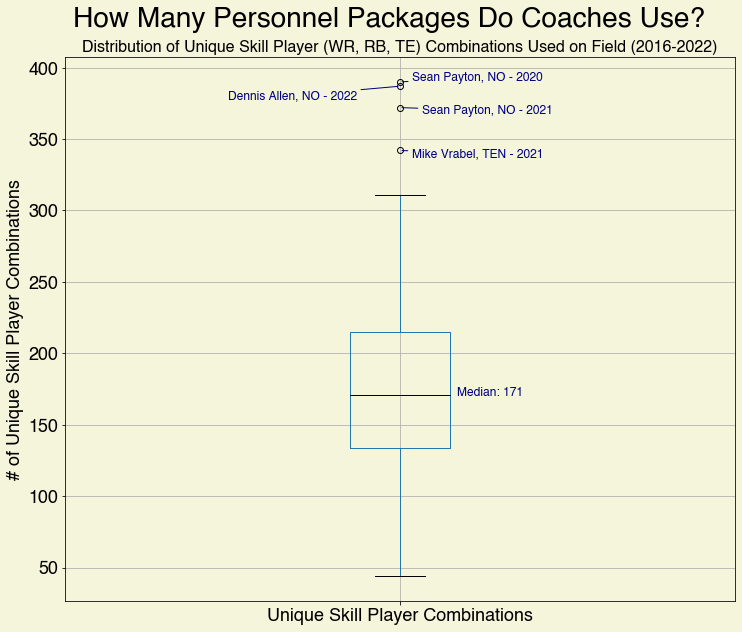

In [284]:
from adjustText import adjust_text
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# Define custom font
font = {'family': 'Helvetica',
        'weight': 'bold',
        'size': 18}  # Increase the font size
mpl.rc('font', **font)

# Create a new dataframe for the boxplot
boxplot_data = pd.DataFrame(
    {'Unique Skill Player Combinations': epa_per_play['players']})

# Plot the data
fig, ax = plt.subplots(figsize=(12, 10))
bp = boxplot_data.boxplot(ax=ax, return_type='dict')

# Change color of median line to black
for median in bp['medians']:
    median.set(color='black')

# Change the background color to beige
fig.patch.set_facecolor('beige')
ax.set_facecolor('beige')

# Optional customizations
plt.suptitle('How Many Personnel Packages Do Coaches Use?', fontsize=28,
             y=0.95, ha='center')  # Increase font size, adjust position and center the title
plt.title("Distribution of Unique Skill Player (WR, RB, TE) Combinations Used on Field (2016-2022)",
          fontsize=16, y=1.0, ha='center')  # Increase font size, adjust position and center the title
plt.ylabel('# of Unique Skill Player Combinations',
           fontsize=18)  # Increase font size

# Identify and label outliers in the 'Unique Skill Player Combinations' series
Q1 = boxplot_data['Unique Skill Player Combinations'].quantile(0.25)
Q3 = boxplot_data['Unique Skill Player Combinations'].quantile(0.75)
IQR = Q3 - Q1
outliers = boxplot_data['Unique Skill Player Combinations'][
    ((boxplot_data['Unique Skill Player Combinations'] < (Q1 - 1.5 * IQR)) |
     (boxplot_data['Unique Skill Player Combinations'] > (Q3 + 1.5 * IQR)))]

# Create empty list to store the text objects for the adjust_text function
texts = []

for outlier in outliers.index:
    text = ax.annotate(f"{epa_per_play.loc[outlier, 'coach']}, {epa_per_play.loc[outlier, 'posteam']} - {epa_per_play.loc[outlier, 'season']}",
                       (1, outliers[outlier]),
                       textcoords="offset points",  # specify coordinates as offset points from data
                       xytext=(0, -10),  # specify x and y offset in points
                       ha='center',  # center text horizontally
                       fontsize=12,  # smaller font size for the annotations
                       color='navy',  # color of the annotation text
                       arrowprops=dict(arrowstyle="-", color='navy'))  # add an arrow pointing to the outliers
    texts.append(text)

# Annotate medians
for i, median in enumerate(bp['medians']):
    texts.append(ax.annotate(f"Median: {int(median.get_ydata()[0])}",
                             (i+1, median.get_ydata()[0]),
                             xytext=(55, -5),  # specify x and y offset in points
                             textcoords='offset points',
                             fontsize=12,  # smaller font size for the annotations
                             color='navy'))  # color of the annotation text

# Adjust the position of non-overlapping annotations
adjust_text(texts)

# Save the plot as a high-quality image
plt.savefig('../images/boxplot_numplayers_per_team.png',
            dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


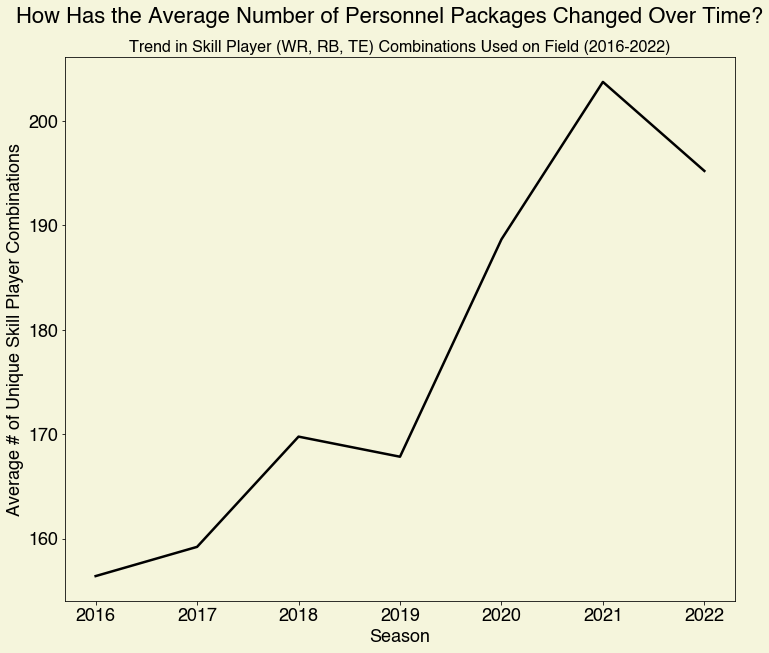

In [285]:
# Assuming 'epa_per_play' DataFrame contains 'season' column and 'players' column is numeric
average_combinations_per_season = epa_per_play.groupby('season')[
    'players'].mean()

fig, ax = plt.subplots(figsize=(12, 10))

# Change the background color to beige
fig.patch.set_facecolor('beige')
ax.set_facecolor('beige')

average_combinations_per_season.plot(
    kind='line', ax=ax, color='black', linewidth=2.5)

# Set title and labels for axes
plt.suptitle('How Has the Average Number of Personnel Packages Changed Over Time?', fontsize=22,
             y=0.95, ha='center')  # Increase font size, adjust position and center the title
plt.title("Trend in Skill Player (WR, RB, TE) Combinations Used on Field (2016-2022)",
          fontsize=16, y=1.0, ha='center')  # Increase font size, adjust position and center the title
plt.xlabel('Season', fontsize=18)
plt.ylabel('Average # of Unique Skill Player Combinations',
           fontsize=18)  # Increase font size

plt.savefig('../images/lineplot_avg_numplayers_per_season.png',)

# Display the plot
plt.show()


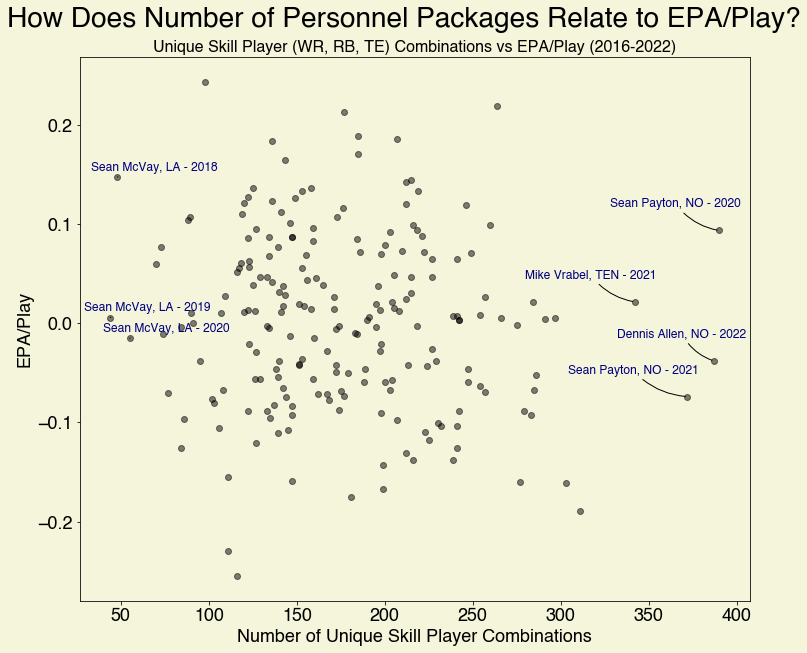

In [286]:
from adjustText import adjust_text
from scipy.stats import linregress

fig, ax = plt.subplots(figsize=(12, 10))

# Change the background color to beige
fig.patch.set_facecolor('beige')
ax.set_facecolor('beige')

# Create the scatter plot
scatter = ax.scatter(epa_per_play['players'], epa_per_play['epa_per_play'],
                     alpha=0.5, color='black')

# Set title and labels for axes
plt.suptitle('How Does Number of Personnel Packages Relate to EPA/Play?', fontsize=28,
             y=0.95, ha='center')  # Increase font size, adjust position and center the title
plt.title("Unique Skill Player (WR, RB, TE) Combinations vs EPA/Play (2016-2022)",
          fontsize=16, y=1.0, ha='center')  # Increase font size, adjust position and center the title
plt.xlabel('Number of Unique Skill Player Combinations', fontsize=18)
plt.ylabel('EPA/Play', fontsize=18)  # Increase font size

# Create empty list to store the text objects for the adjust_text function
texts = []

# Get the median
median = epa_per_play['players'].median()

# Label points based on criteria
for i, txt in enumerate(epa_per_play['players']):
    if txt > 340 or txt < 70:
        # Determine the x offset based on the position of the point relative to the median
        x_offset =  -30 if txt < median else 25
        texts.append(
            ax.annotate(
                f"{epa_per_play['coach'].iloc[i]}, {epa_per_play['posteam'].iloc[i]} - {epa_per_play['season'].iloc[i]}",
                xy=(txt, epa_per_play['epa_per_play'].iloc[i]
                    ), xycoords='data',
                xytext=(x_offset, 0), textcoords='offset points',
                arrowprops=dict(arrowstyle="-", connectionstyle="arc3,rad=.2"),
                fontsize=12, color='navy'
            )
        )

# Adjust the position of non-overlapping annotations if there are any
if texts:
    adjust_text(texts)

plt.savefig('../images/scatterplot_numplayers_vs_epa.png',
            dpi=300, bbox_inches='tight')

# Display the plot
plt.show()


In [290]:
# sort by number of players
epa_per_play.sort_values(by='players', inplace=True)

In [291]:
epa_per_play

,season,posteam,epa_per_play,coach,percentage,players
105,2019,LA,0.005712,Sean McVay,1.0,44
74,2018,LA,0.147311,Sean McVay,1.0,48
132,2020,LA,-0.015198,Sean McVay,1.0,55
101,2019,HOU,0.059995,Bill O'Brien,1.0,70
163,2021,LA,0.076691,Sean McVay,1.0,73
...,...,...,...,...,...,...
188,2022,HOU,-0.188910,Lovie Smith,1.0,311
176,2021,TEN,0.021559,Mike Vrabel,1.0,342
168,2021,NO,-0.073969,Sean Payton,1.0,372
197,2022,NO,-0.037977,Dennis Allen,1.0,387
